In [1]:
%%writefile gmm.py

import numpy as np
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import multivariate_normal as mvn_random
from scipy.stats import multivariate_normal
from numpy.random import normal, uniform
from scipy.stats import mode


class Component:
    def __init__(self, mixture_prop, mean, variance):
        self.mixture_prop = mixture_prop
        self.mean = mean
        self.variance = variance

class GMMFromScratch:
    def __init__(self, k, iterations):
        self.k = k
        self.iterations = iterations
        self.gmm_params = []

    def fit(self, dataset):
        self.expectation_maximization(dataset)

    def expectation_maximization(self, dataset):
        self.gmm_init(dataset)
        probs = None
        for _ in range(self.iterations):
            probs = self.compute_probs(dataset)
            self.compute_gmm(dataset, probs)
        return probs

    def gmm_init(self, dataset):
        kmeans = KMeans(self.k, init='k-means++').fit(np.array(dataset))
        for j in range(self.k):
            idx = np.where(kmeans.labels_ == j)[0]
            p_cj = len(idx) / len(dataset)
            mean_j = np.mean(np.array(dataset)[idx], axis=0)
            var_j = np.cov(np.array(dataset)[idx].T) + np.eye(dataset.shape[1]) * 1e-6
            self.gmm_params.append(Component(p_cj, mean_j, var_j))

    def compute_probs(self, dataset):
        probs = []
        for data_point in dataset:
            p_cj_xi = []
            for component in self.gmm_params:
                p_xi_cj = multivariate_normal.pdf(data_point, mean=component.mean, cov=component.variance, allow_singular=True)
                p_cj_xi.append(component.mixture_prop * p_xi_cj)
            p_cj_xi = np.array(p_cj_xi) / sum(p_cj_xi)
            probs.append(p_cj_xi)
        return np.array(probs)

    def compute_gmm(self, dataset, probs):
        n_samples = len(dataset)
        self.gmm_params = []
        for j in range(self.k):
            p_cj = sum(probs[i][j] for i in range(n_samples)) / n_samples
            mean_j = np.sum([probs[i][j] * dataset[i] for i in range(n_samples)], axis=0) / np.sum([probs[i][j] for i in range(n_samples)])
    
            # Accumulate the covariance matrix with regularization to avoid singular matrices
            var_j = np.sum([probs[i][j] * np.outer(dataset[i] - mean_j, dataset[i] - mean_j) for i in range(n_samples)], axis=0)
            var_j /= np.sum(probs[:, j])
            var_j += np.eye(dataset.shape[1]) * 1e-6  # Regularization term
    
            if np.any(np.isnan(var_j)) or np.any(np.isinf(var_j)):
                var_j = np.eye(dataset.shape[1]) * 1e-6  # Reset to prevent NaN or inf
    
            self.gmm_params.append(Component(p_cj, mean_j, var_j))
            
    def predict(self, dataset):
        probs = self.compute_probs(dataset)
        return np.argmax(probs, axis=1)

  



Overwriting gmm.py


In [5]:
%%writefile examine.py

from gmm import GMMFromScratch
import numpy as np
import pandas as pd
from scipy.stats import mode

np.random.seed(42)

train_data = pd.read_csv('vowel_train.txt')
test_data = pd.read_csv('vowel_test.txt')

X_train = train_data.iloc[:, 2:].values
y_train = train_data.iloc[:, 1].values
X_test = test_data.iloc[:, 2:].values
y_test = test_data.iloc[:, 1].values

# Initialize and fit the GMM 
gmm_model = GMMFromScratch(k=11, iterations=100)
gmm_model.expectation_maximization(X_train)

predicted_clusters = gmm_model.predict(X_test)

cluster_to_label_mapping = {}
training_predictions = gmm_model.predict(X_train)

for cluster in np.unique(training_predictions):
    labels_in_cluster = y_train[training_predictions == cluster]
    if labels_in_cluster.size > 0:
        common_label_mode = mode(labels_in_cluster)
        most_common_label = common_label_mode.mode.item()  # safely extract the mode value
        cluster_to_label_mapping[cluster] = most_common_label
    else:
        # Handle the case where a cluster is empty
        cluster_to_label_mapping[cluster] = np.random.choice(y_train)

predicted_labels = np.array([cluster_to_label_mapping.get(cluster, np.random.choice(y_train)) for cluster in predicted_clusters])

# Calculate the misclassification rate
if predicted_labels.shape[0] == y_test.shape[0]:
    misclassification_rate = np.mean(predicted_labels != y_test)
    print(f'Misclassification Rate: {misclassification_rate * 100:.2f}%')
else:
    print("Error: Predicted labels and test labels have mismatched lengths.")

Overwriting examine.py


In [26]:
train_data

,row.names,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
0,1,1,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
1,2,2,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488
2,3,3,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049
3,4,4,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795
4,5,5,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396
...,...,...,...,...,...,...,...,...,...,...,...,...
523,524,7,-4.065,2.876,-0.856,-0.221,-0.533,0.232,0.855,0.633,-1.452,0.272
524,525,8,-4.513,4.265,-1.477,-1.090,0.215,0.829,0.342,0.693,-0.601,-0.056
525,526,9,-4.651,4.246,-0.823,-0.831,0.666,0.546,-0.300,0.094,-1.343,0.185
526,527,10,-5.034,4.993,-1.633,-0.285,0.398,0.181,-0.211,-0.508,-0.283,0.304


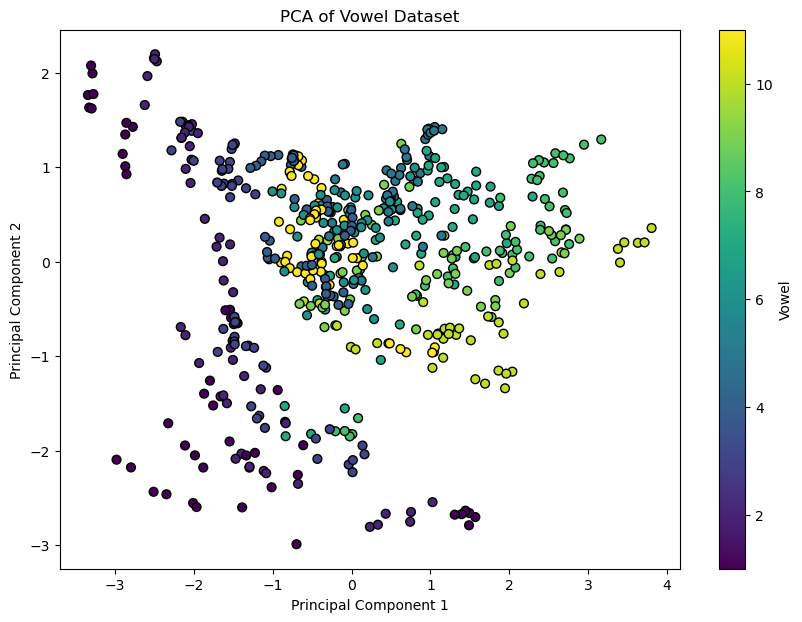

In [3]:
%%writefile PCA2D.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode

class PCAFromScratch:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        data_centered = data - self.mean
        
        covariance_matrix = np.cov(data_centered, rowvar=False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        self.components = eigenvectors[:, :self.n_components]

    def transform(self, data):
        data_centered = data - self.mean
        return np.dot(data_centered, self.components)

data = pd.read_csv('vowel_train.txt')
X = data.drop(['row.names', 'y'], axis=1).values
y = data['y'].values

pca = PCAFromScratch(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
plt.title('PCA of Vowel Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Vowel')
plt.show()


In [2]:
%%writefile PCA3D.py

from gmm import GMMFromScratch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

class PCAFromScratch:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        data_centered = data - self.mean
        
        covariance_matrix = np.cov(data_centered, rowvar=False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        self.components = eigenvectors[:, :self.n_components]

    def transform(self, data):
        data_centered = data - self.mean
        return np.dot(data_centered, self.components)


test_data = pd.read_csv('vowel_test.txt')
X_test = test_data.drop(['row.names', 'y'], axis=1).values

pca = PCAFromScratch(n_components=3)
pca.fit(X_test)  
X_test_pca = pca.transform(X_test)

train_data = pd.read_csv('vowel_train.txt')
X_train = train_data.iloc[:, 2:].values
y_train = train_data.iloc[:, 1].values
gmm_model = GMMFromScratch(k=11, iterations=100)
gmm_model.fit(X_train)  
gmm_predictions = gmm_model.predict(X_test)

class_to_color_map = {
    1: "red",
    2: "blue",
    3: "green",
    4: "yellow",
    5: "orange",
    6: "purple",
    7: "pink",
    8: "brown",
    9: "gray",
    10: "olive",
    11: "cyan",
}
colors = [class_to_color_map[label + 1] for label in gmm_predictions]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=colors, s=50)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D Scatter Plot of Vowel Data with GMM Classification")

plt.show()


Overwriting PCA3D.py
